In [4]:
# from src.SensitivityAnalysis import load_data
import matplotlib.pyplot as plt
import pandas as pd
from src.SugarScape import SugarScape
from mesa import batch_run
import numpy as np
from tqdm import tqdm

# Finding Parameters

In [ ]:
data = load_data()
averaged = []
for i in range(len(data) // 10 - 1):
    trader_mean = data['Trader Count'].iloc[i*10:(i+1)*10].mean()
    gini_mean = data['Gini'].iloc[i*10:(i+1)*10].mean()
    
    if trader_mean > 0:
        averaged.append(1 / gini_mean * trader_mean)


In [ ]:
# Find where gini maximized 
worst = dict(data.iloc[np.argmin(averaged)])
best = dict(data.iloc[np.argmax(averaged)])

worst = {key: float(value) for (key,value) in worst.items()}
best = {key: float(value) for (key,value) in best.items()}

print(f'Worst case: {worst}')
print(f'Best case: {best}')

# Find closest to average
dist = (averaged - np.mean(averaged))**2
idx = np.argmin(dist)

typical = dict(data.iloc[idx * 10])
typical = {key: float(value) for (key,value) in typical.items()}
print(f'Typical: {typical}')


# Run Base Simulations

In [ ]:
## USe these map schemes based on your name
# Priyank: top-heavy
# Amish: uniform
# Ilia: split

map_scheme = 'split'

scenarios = [
    {'vision_mean': 4.264199728146195, 'metabolism_mean': 6.751366691663861, 'max_age_mean': 96.55008263885976,
     'repopulate_factor': 7.485186895355582, 'cell_regeneration': 1.6743798777461052, 'map_scheme': map_scheme},   # Worst case
    
    {'vision_mean': 2.571960593573749, 'metabolism_mean': 7.285224918276071, 'max_age_mean': 93.18476642481984,
     'repopulate_factor': 5.733334645628929, 'cell_regeneration': 2.95167014375329, 'map_scheme': map_scheme},     # Best case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344,
     'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},  # Average case
    
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'map_scheme': map_scheme},                                   # Balanced case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 100,
     'repopulate_factor': 5, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},                    # Slow evolving
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                    # Fast evolving
]

results = []
replicates = 30
max_steps = 200

In [ ]:
for scenario in scenarios:
    batch = batch_run(SugarScape, scenario, number_processes=None,
                      iterations=replicates, max_steps=max_steps, display_progress=True, data_collection_period=1)
    for i in range(replicates):
        scenario["Gini"] = [val['Gini'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
        scenario["Trader Count"] = [val['Trader Count'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]

        results.append(list(scenario.values()))

# Convert to df and save
names = list(scenario.keys()) 
df = pd.DataFrame(results, columns=names)
df.to_csv(f'Experiments/Base/results_{map_scheme}.csv')

In [ ]:
def safe_eval(value):
    try:
        return eval(value)
    except:
        return value

names = ['Worst', 'Best', 'Typical', 'Balanced', 'Slow evolving', 'Fast evolving']
for map_scheme in ['uniform', 'top_heavy', 'split']:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    df = pd.read_csv(f'Experiments/Base/results_{map_scheme}.csv')
    df['Gini'] = df['Gini'].apply(safe_eval)
    df['Trader Count'] = df['Trader Count'].apply(safe_eval)
    
    for i in range(len(scenarios)):
        # Get gini and trader count of every scenario
        gini = df.iloc[i*replicates:(i+1)*replicates]['Gini']
        trader = df.iloc[i*replicates:(i+1)*replicates]['Trader Count']
        
        # Convert to 2d np arrays
        gini = np.vstack(gini)
        trader = np.vstack(trader)
        
        # Get means and ci
        gini_mean = np.mean(gini, axis=0)
        gini_ci = np.std(gini, ddof=1, axis=0) / replicates * 1.96
        trader_mean = np.mean(trader, axis=0)
        trader_ci = np.std(trader, ddof=1, axis=0) / replicates * 1.96
        
        # Plotting
        x = np.arange(len(gini_mean))
        ax[0].plot(x, gini_mean, label=names[i])
        ax[0].fill_between(x, gini_mean + gini_ci, gini_mean - gini_ci, alpha=0.5)
        ax[1].plot(x, trader_mean, label=names[i])
        ax[1].fill_between(x, trader_mean + trader_ci, trader_mean - trader_ci, alpha=0.5)
    
    # Set labels, grid and title
    ax[1].legend(bbox_to_anchor=(1, 1.05))
    ax[0].set_title('Gini')
    ax[1].set_title('Trader Count')
    for i in range(2):
        ax[i].grid()
        ax[i].set_xlabel('Timesteps')
    ax[0].set_ylabel('Gini Coefficient')
    ax[1].set_ylabel('Number of Traders')
    
    # Save figure
    fig.suptitle(f'{map_scheme}')
    fig.tight_layout()
    fig.savefig(f'Experiments/Base/plot_{map_scheme}.png', dpi=300, bbox_inches='tight')

# Running Experiments

In [ ]:
## Use these map schemes based on your name
# Priyank: top-heavy
# Amish: uniform
# Ilia: split

map_scheme = 'uniform'

scenarios = [
    {'vision_mean': 4.264199728146195, 'metabolism_mean': 6.751366691663861, 'max_age_mean': 96.55008263885976,
     'repopulate_factor': 7.485186895355582, 'cell_regeneration': 1.6743798777461052, 'map_scheme': map_scheme},   # Worst case
    
    {'vision_mean': 2.571960593573749, 'metabolism_mean': 7.285224918276071, 'max_age_mean': 93.18476642481984,
     'repopulate_factor': 5.733334645628929, 'cell_regeneration': 2.95167014375329, 'map_scheme': map_scheme},     # Best case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344,
     'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},  # Average case
    
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'map_scheme': map_scheme},                                   # Balanced case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 100,
     'repopulate_factor': 5, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},                    # Slow evolving
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                    # Fast evolving
]


tax_systems = [
    ("progressive", "needs"),
    ("flat", "flat"),
    ("regressive", "random"),
    ("luxury", "progressive"),
    ("progressive", "progressive")
]

tax_rates = [0.1, 0.25, 0.4]

results = []
replicates = 30
max_steps = 200

In [ ]:
with tqdm(total=len(scenarios), ncols=70) as pbar:
    for scenario in scenarios:
        for tax_system in tax_systems:
            for tax_rate in tax_rates:
                scenario_copy = scenario.copy()
                # Adding taxsystem and rate into scenario
                scenario_copy['tax_scheme'] = tax_system[0]
                scenario_copy['distributer_scheme'] = tax_system[1]
                scenario_copy['tax_rate'] = tax_rate
        
                batch = batch_run(SugarScape, scenario_copy, number_processes=None,
                                  iterations=replicates, max_steps=max_steps, display_progress=False, data_collection_period=1)
                for i in range(replicates):
                    scenario_copy["Gini"] = [val['Gini'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
                    scenario_copy["Trader Count"] = [val['Trader Count'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
    
                results.append(list(scenario_copy.values()))
    
        pbar.update(1)

# Convert to df and save
names = list(scenario_copy.keys()) 
df = pd.DataFrame(results, columns=names)
df.to_csv(f'Experiments/results_{map_scheme}.csv')

# Plotting Taxes Experiment 

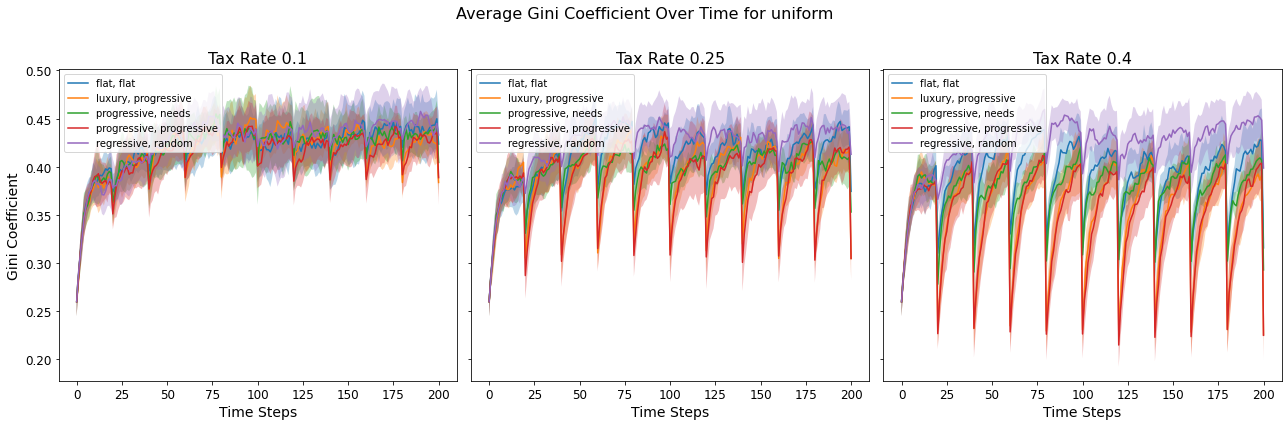

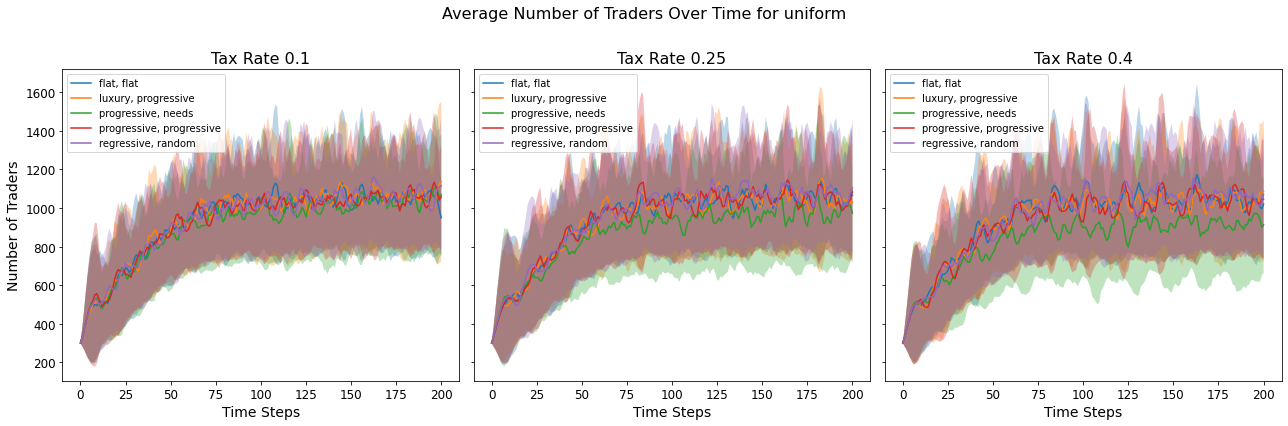

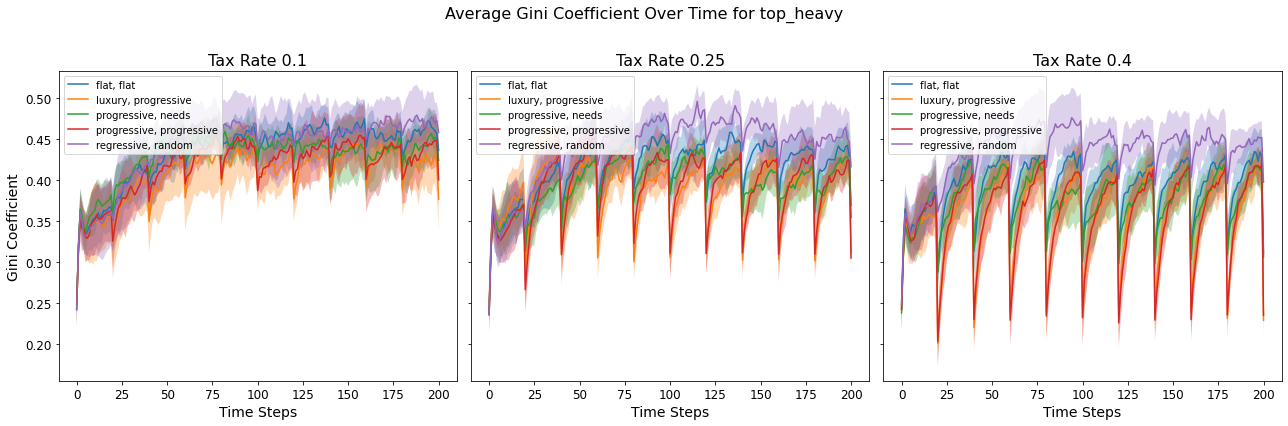

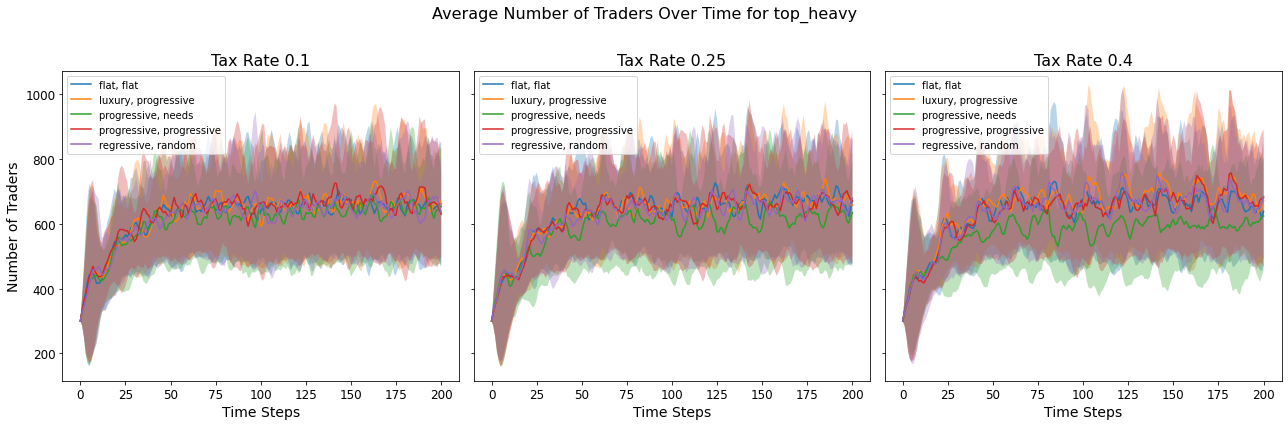

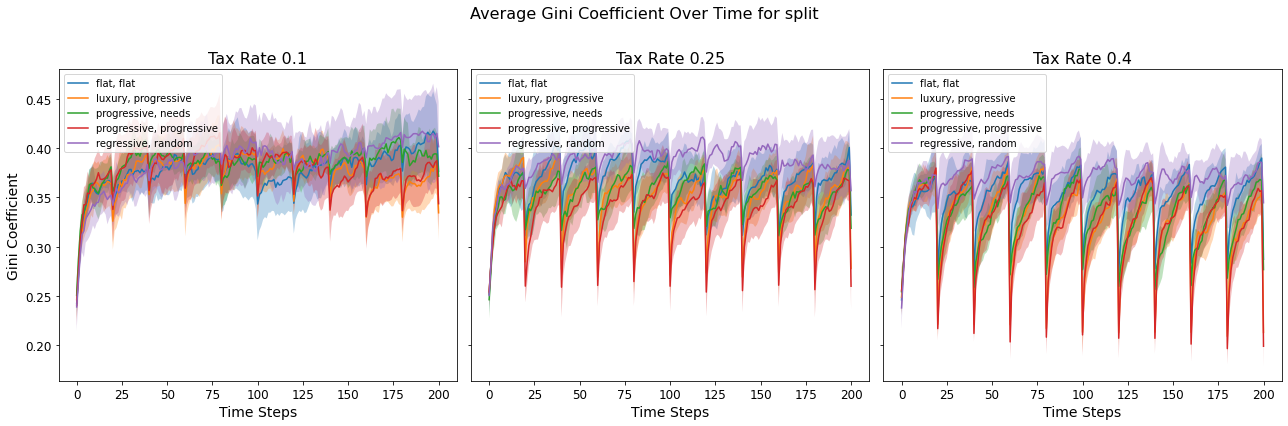

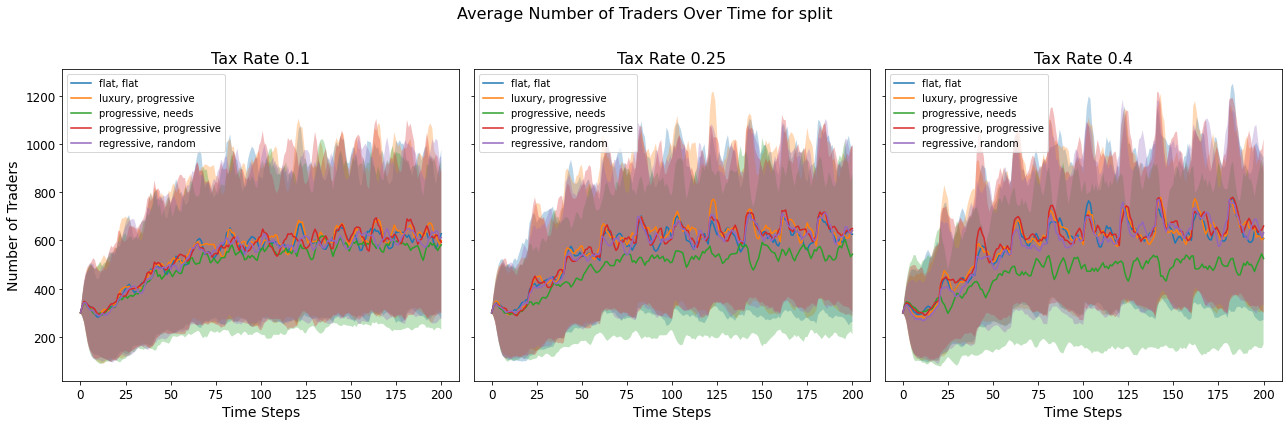

In [22]:


def load_and_process(file_path):
    """Load CSV file and process the data."""
    data = pd.read_csv(file_path)
    
    def convert_str_to_list(list_str):
        # Strip unnecessary characters and split the string
        list_str = list_str.replace('np.float64(', '').replace(')', '').strip('[]')
        list_str = list_str.split(',')
        return [float(x.strip()) for x in list_str]

    # Apply the conversion to the relevant columns
    data['Gini'] = data['Gini'].apply(lambda x: convert_str_to_list(x) if isinstance(x, str) else x)
    data['Trader Count'] = data['Trader Count'].apply(lambda x: convert_str_to_list(x) if isinstance(x, str) else x)
    
    return data

def plot_results(data, title, metric, y_label, filename):
    """Plot the average and 95% CI of the metric over time and save the plot as an image."""
    tax_rates = data['tax_rate'].unique()
    
    fig, axs = plt.subplots(1, len(tax_rates), figsize=(18, 6), sharey=True)
    fig.patch.set_facecolor('white')

    for ax, tax_rate in zip(axs, tax_rates):
        subset = data[data['tax_rate'] == tax_rate]
        
        for (tax_scheme, distributer_scheme), group_data in subset.groupby(['tax_scheme', 'distributer_scheme']):
            time_steps = np.arange(len(group_data.iloc[0][metric]))
            values = np.array(group_data[metric].tolist())
            mean_values = np.mean(values, axis=0)
            std_error = np.std(values, axis=0) / np.sqrt(values.shape[0])
            ci95 = 1.96 * std_error

            label = f"{tax_scheme}, {distributer_scheme}"
            ax.plot(time_steps, mean_values, label=label)
            ax.fill_between(time_steps, mean_values - ci95, mean_values + ci95, alpha=0.3)

        ax.set_xlabel('Time Steps', fontsize=14)
        ax.set_title(f'Tax Rate {tax_rate}', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend(loc='upper left', fontsize=10)

    axs[0].set_ylabel(y_label, fontsize=14)
    fig.suptitle(f'Average {y_label} Over Time for {title}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'plots/{filename}', bbox_inches='tight')
    plt.show()

# Load data from the files
file_paths = [
    'Experiments/results_uniform.csv',
    'Experiments/results_top_heavy.csv',
    'Experiments/results_split.csv'
]

titles = ['uniform', 'top_heavy', 'split']

all_data = [load_and_process(file_path) for file_path in file_paths]

# Plot results for each file and save the plots
for data, title in zip(all_data, titles):
    plot_results(data, title, 'Gini', 'Gini Coefficient', f'{title}_gini_over_time.png')
    plot_results(data, title, 'Trader Count', 'Number of Traders', f'{title}_agents_over_time.png')
